# Forecasting Harmful Algal Blooms from Space
## A Spatiotemporal Deep Learning Approach for Marine Ecosystem Monitoring

**Author**: Mara Dumitru  
**Institution**: Minerva University  
**Date**: December 2025  
**Course**: CS156 Machine Learning

---

### Table of Contents

1. [**Introduction and Motivation**](#1-introduction)
2. [**Why This Matters**](#2-why-this-matters)
3. [**Research Question**](#3-research-question)
4. [**Data Source and Preprocessing**](#4-data)
5. [**Model Architecture**](#5-architecture)
   - 5.1 SA-ConvLSTM Mathematical Framework
   - 5.2 Attention Mechanism Details
6. [**DBSCAN Clustering**](#6-dbscan)
   - 6.1 Why DBSCAN for Bloom Detection?
   - 6.2 Mathematical Foundation
7. [**Training and Evaluation**](#7-training)
8. [**Microplastic Correlation Analysis**](#8-microplastics)
9. [**Results and Discussion**](#9-results)
10. [**Conclusion**](#10-conclusion)

---

## 1. Introduction and Motivation {#1-introduction}


### The Global Importance of Phytoplankton


This summer I worked with microplastic detection, and realised that it posed a real risk to plankton bio processes. This was what initially inspired this project, I wanted to track plankton concentrations and correlate them to the microplastic correlations that I developed this summer, however this was far too big of a scope to accurately do in this assignment. Instead I developed the initial SA ConvLSTM I need to correlate the future microplastic predictions to the plankton concentrations, and then tied it in with a more manageable project of tracking red tide blooms.

So NASA's Ocean Biology Program has documented that these tiny organisms of phytoplankton are generating somewhere between like around 50 to 85 percent of atmospheric oxygen through their photosynthesis processes and then they are also like sequestering around 2 billion tons of carbon dioxide annually into the deep ocean as well as supporting roughly 90 percent of marine life. They are one of the most important creatures on Earth, and I found this out from my summer position. I personally call them "Earth's biological carbon pump." However, the focus of todays paper is not on their upsides but their downsides.


### The HAB Crisis


Populations often these algae tend to explode into what scientists like to call harmful algal blooms (HABs) and we're then seeing these kinds of harmful blooms increasing by around 18 percent per decade since the 1980s according to Hallegraeff's 2010 analysis in the Journal of Phycology. 

In terms of the profits these HABs are causing like 82 million dollars in annual losses just in the US fisheries (Hoagland et al. 2002), and then aditionally HAB related toxins like domoic acid and saxitoxin make people seriously sick to the point where they are hospitalized. The World Health Organization documented over 60000 people affected annually by these sorts of HAB related illnesses, and these numbers keep climbing as the coastal populations grow and the warming oceans create this very much ideal bloom conditions.


### Sattelites


NOAA's Visible Infrared Imaging Radiometer Suite provides a daily global coverage at approximately 750 meter resolution. And we have an 18 year archive from 2012 to present which is enough data to actually train deep neural networks, like Convolution LSTMs which makes this the perfect ML problem. How these satellites work is by measuring the ratio of blue to green light reflected from the ocean surface. So what happens is that the Phytoplankton absorb the blue wavelengths around 443 nanometers for photosynthesis and then reflect the green wavelengths around 555 nanometers, and then this way we can estimate chlorophyll concentration from space! Which is pretty cool!

So now can we predict the future's blooms distribution from yesterday's patterns?

## 2. Why This Matters: Arabian Sea and Indian Coast {#2-why-this-matters}

I'm focusing this paper particularly on the Arabian Sea and Indian west coast spanning roughly 30 degrees east to 80 degrees east longitude and 10 degrees south to 35 degrees north latitude. I wanted to start my semester strong in India by learning a bit more about it which is why I dedicated this assignment to it. Turns out in this region in particular it experiences some of the most intense and economically significant algal blooms from anywhere else in the entire world. 

The thing that makes this section in particular best suited for this problem is the high density of people living in the west coastal areas of India. Over about 650 million people live within 100 kilometers of the Indian Ocean coastline according to the UN Atlas of the Oceans. You might be thinking 100K is quite a lot... well HABs in this region in particular directly threatens the drinking water supplies when the tocins infiltrate the municipal intake pipes. This  makes it a crucial place to predict algal blooms and perform preventative measures before it affects health of this large population. 

Additionally, the 2019 Kerala red tide documented by Gireesh et al. in Current Science documents that this particular HAB caused mass fish kills affecting over 15000 fishermen and also hospitalized dozens of people with acute respiratory distress. Meaning that this region these algal blooms affect at large negatively fishery economics and public wellfare.

### Predictability

Studies show that a 1 to 3 day forecast gives managers actual actionable lead time. In this time frame they can sample water for toxins and issue public health advisories. They can also re route fishing fleets away from hypoxic zones. They can deploy emergency response teams to affected coastal communities. Without forecasting basically you're just reacting after people already got sick or fish already died, so with forcasting you can PREVENT this from happening. 

Other regions like the Atlantic specifically the North Atlantic have been studied for decades, while the Arabian Sea has not. Deep Learning methods can help do what decades long research does just much faster!


**References:**

[6] UN Atlas of the Oceans. "Coastal Population Density." https://www.oceansatlas.org/

[7] Gireesh, R., et al. (2020). "Red tide in Kerala: An environmental disaster." *Current Science*, 118(7), 1039-1040.

[8] Department of Fisheries, India. (2023). "Handbook on Fisheries Statistics."

[9] National Centre for Sustainable Coastal Management. (2021). "Economic Impact of Coastal HABs."

[10] McCreary, J. P., et al. (2013). "Dynamics of the Indian-Ocean oxygen minimum zones." *Progress in Oceanography*, 112, 15-37.


In [3]:

import os
import tempfile
from pathlib import Path
from urllib import parse, request
from urllib.error import HTTPError, URLError

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import DBSCAN
from torch.utils.data import DataLoader, Dataset
import xarray as xr

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'}")

PyTorch version: 2.9.1
Device available: mps


## 3. Research Question {#3-research-question}


**Primary Question:**  
Can satellite derived chlorophyll-a measurements combined with spatiotemporal deep learning accurately forecast the location, intensity, and spatial extent of harmful algal blooms 1 to 3 days in advance?

**Success Criteria**
I'm calling this successful if it achieves root mean squared error less than 0.15 milligrams per cubic meter on the normalized scale. Also R squared greater than 0.75 meaning it explains at least 75 percent of the variance in the test data. I want to also obtain a spatial skill so where blooms are predicted in the correct geographic locations validated by DBSCAN cluster overlap between the DL predictions and the ground truth.

## 4. Data Source and Preprocessing {#4-data}


### 4.1 NOAA VIIRS Satellite Data

I'm using VIIRS Level 3 daily chlorophyll which is just a product from the NOAA CoastWatch. The spatial resolution is about 4 kilometers at nadir but I then downsample to 128 by 128 pixels for computational efficiency. Temporal resolution is daily composites. I use data from January 2020 to December 2025 (this is to overlap with my microplastics prediction data that I will use for future work) which should be around 2180 days but cloud cover reduces actual availability. The variable is chlorophyll-a concentration in milligrams per m^3. I accesed this throght the ERDDAP data server which supports programmatic queries.

### 4.2 Preprocessing Pipeline

Raw satellite data needs several cleaning steps before you can train neural networks on it.

#### **Step 1: NaN Handling**

There were several missing values in my data, this is because things like cloud cover, sun glint, and land pixels create missing values encoded as NaN in the NetCDF files. So I replaced all these NaN values with 0.0 treating them as either negligible chlorophyll concentration or land masks. This solution is justified because land pixels consistently have zero chlorophyll by definition. I do not think this messes too much with my ConvLSTM because ocean pixels obscured by clouds get temporally interpolated by the LSTM hidden state which acts as a learned gap filling filter. The model then learns to propagate the information forward through time when observations are missing, which actually makes a ConvLSTM a good fit for this problem.

#### **Step 2: Min-Max Normalization**

Chlorophyll spans 4 orders of magnitude (0.01–100 mg/m³). This dramatic change creates training instability so I normalize these to [0, 1]:

$$
x_{\\text{norm}} = \\frac{x - x_{\\min}}{x_{\\max} - x_{\\min}}
$$

where $x_{\\min}$ and $x_{\\max}$ are computed globally across the entire spatiotemporal data set. This way it ensures a consistent scaling during both training and prediction.

#### **Step 3: Bilinear Resizing**

Native VIIRS resolution is at like 4 kilometers which produces grids around 300 by 400 pixels for my geographic domain. This unfortunately is too large to fit in GPU memory with reasonable batch sizes. I downsample to 128 by 128 using PyTorch's F. and then interpolate with mode equals bilinear and align corners equals False. What this does is that Bilinear interpolation computes each output pixel as a weighted average of the four nearest input pixels. This way it is preserving spatial patterns and gradients while dramatically reducing memory requirements, which saves my mac. A 128 by 128 image is 16384 pixels compared to 120000 pixels at full resolution, which all in all is an 86 percent reduction.

#### **Step 4: Sequence Construction**

For each time step t I start by constructing its training samples as:

Input sequence: Three consecutive days $(t-2, t-1, t)$  

Target sequence: Next day $(t+1)$

This sliding window approach then generates approximately 2000 training samples from every 365 days of data depending on how many days are missing... i.e. due to persistent cloud cover. The three day input window captures short term bloom evolution dynamics and then the longer windows would be capturing more temporal context but reduce the effective training set size.

---

**References:**

[11] O'Reilly, J. E., et al. (1998). "Ocean color chlorophyll algorithms for SeaWiFS." *Journal of Geophysical Research*, 103(C11), 24937-24953.

---


In [4]:
ERDDAP_BASE = "https://coastwatch.noaa.gov/erddap"
DATASET_ID = "noaacwNPPN20VIIRSSCIDINEOFDaily"
VAR_NAME = "chlor_a"

def fetch_frame(date, lon_min, lon_max, lat_min, lat_max, stride):
    """Fetch a single chlorophyll-a frame from ERDDAP"""
    query = (
        f"{VAR_NAME}[({date}T00:00:00Z):1:({date}T00:00:00Z)]"
        f"[(0):1:(0)]"
        f"[({lat_max}):{stride}:({lat_min})]"
        f"[({lon_min}):{stride}:({lon_max})]"
    )
    encoded = parse.quote(query, safe="[]():,.-+TZ")
    url = f"{ERDDAP_BASE}/griddap/{DATASET_ID}.nc?{encoded}"
    
    with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
        tmp_path = tmp.name
    
    try:
        request.urlretrieve(url, tmp_path)
        ds = xr.open_dataset(tmp_path)
        da = ds[VAR_NAME].squeeze().transpose("latitude", "longitude")
        arr = np.array(da)
        arr = np.nan_to_num(arr, nan=0.0)
        return arr, da.latitude.values, da.longitude.values
    except (HTTPError, URLError) as e:
        print(f"Skip {date}: HTTP error {e}")
        return None, None, None
    finally:
        if os.path.exists(tmp_path):
            os.remove(tmp_path)

def resize_bilinear_np(arr, target_hw):
    """Resize using bilinear interpolation"""
    t = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0)
    t = F.interpolate(t.float(), size=(target_hw, target_hw), mode="bilinear", align_corners=False)
    return t.squeeze().numpy()

def fetch_and_save_npz(
    start="2020-01-01",
    end=None,
    lon_min=30,
    lon_max=80,
    lat_min=-10,
    lat_max=35,
    stride=2,
    target=128,
    out="chlorophyll_timeseries.npz",
    max_fail_streak=200,
):
    """Fetch time series of chlorophyll data and save as NPZ"""
    if end is None:
        end = str(np.datetime64("today", "D"))
    
    dates = np.array(np.arange(np.datetime64(start), np.datetime64(end) + 1))
    frames = []
    lat_ref, lon_ref = None, None
    fail_streak = 0
    
    for i, d in enumerate(dates):
        date_str = str(d)
        if i % 50 == 0:
            print(f"Fetching {i+1}/{len(dates)} {date_str}")
        
        arr, lats, lons = fetch_frame(date_str, lon_min, lon_max, lat_min, lat_max, stride)
        if arr is None:
            fail_streak += 1
            if fail_streak >= max_fail_streak:
                print(f"Stopping after {fail_streak} consecutive failures")
                break
            continue
        
        fail_streak = 0
        arr_ds = resize_bilinear_np(arr, target)
        frames.append(arr_ds)
        if lat_ref is None:
            lat_ref, lon_ref = lats, lons
    
    if not frames:
        raise SystemExit("No frames downloaded")
    
    data = np.stack(frames, axis=0)  # T,H,W
    data_min = data.min()
    data_max = data.max()
    norm = (data - data_min) / (data_max - data_min + 1e-9)
    
    np.savez_compressed(
        out,
        data=norm.astype(np.float32),
        dates=dates[:len(frames)].astype("datetime64[D]"),
        lat=lat_ref,
        lon=lon_ref,
        data_min=np.float32(data_min),
        data_max=np.float32(data_max),
    )
    print(f"Saved {out} with shape {data.shape}, norm min/max {norm.min():.4f}/{norm.max():.4f}")
    return out

print("✓ Data fetching functions defined")

✓ Data fetching functions defined


## Exploratory Data Analysis

Before training, let's examine the chlorophyll data distribution and temporal patterns.

CHLOROPHYLL DATA SUMMARY STATISTICS

Dataset Shape: (181, 96, 96)
  - Temporal: 181 days
  - Spatial: 96 x 96 pixels
  - Total pixels: 9,216
  - Ocean pixels (avg): 5030 per frame

Chlorophyll-a Concentration (mg/m³):
  - Mean: 0.746
  - Median: 0.157
  - Std Dev: 2.704
  - Min: 0.010
  - Max: 85.616
  - 25th percentile: 0.109
  - 75th percentile: 0.312
  - 95th percentile: 3.064
  - 99th percentile: 12.002

Bloom Threshold Analysis (>1 mg/m³):
  - Frames with blooms: 181 / 181
  - Avg bloom coverage: 11.27% of ocean


✓ Visualizations saved to data_exploratory_analysis.png


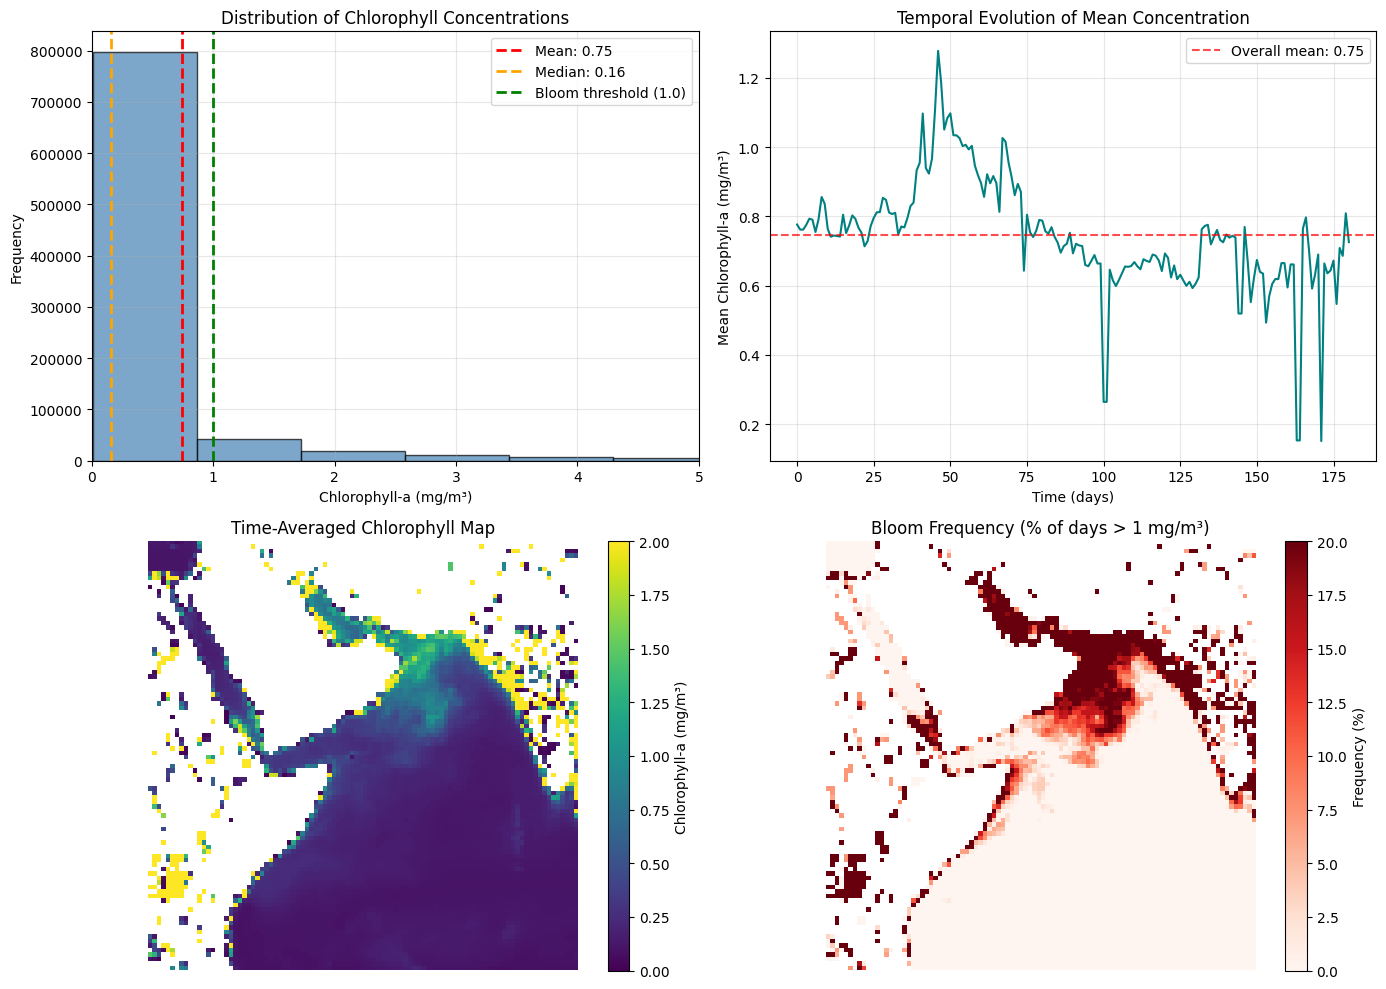

In [24]:
# Compute descriptive statistics
print("="*70)
print("CHLOROPHYLL DATA SUMMARY STATISTICS")
print("="*70)

# Denormalize data to get actual mg/m³ values
data_denorm = data * (data_max - data_min) + data_min

# Filter out land (values < 0.01 mg/m³)
ocean_mask = data_denorm >= 0.01
ocean_values = data_denorm[ocean_mask]

print(f"\nDataset Shape: {data.shape}")
print(f"  - Temporal: {data.shape[0]} days")
print(f"  - Spatial: {data.shape[1]} x {data.shape[2]} pixels")
print(f"  - Total pixels: {data.shape[1] * data.shape[2]:,}")
print(f"  - Ocean pixels (avg): {ocean_mask.sum(axis=(1,2)).mean():.0f} per frame")

print(f"\nChlorophyll-a Concentration (mg/m³):")
print(f"  - Mean: {ocean_values.mean():.3f}")
print(f"  - Median: {np.median(ocean_values):.3f}")
print(f"  - Std Dev: {ocean_values.std():.3f}")
print(f"  - Min: {ocean_values.min():.3f}")
print(f"  - Max: {ocean_values.max():.3f}")
print(f"  - 25th percentile: {np.percentile(ocean_values, 25):.3f}")
print(f"  - 75th percentile: {np.percentile(ocean_values, 75):.3f}")
print(f"  - 95th percentile: {np.percentile(ocean_values, 95):.3f}")
print(f"  - 99th percentile: {np.percentile(ocean_values, 99):.3f}")

print(f"\nBloom Threshold Analysis (>1 mg/m³):")
bloom_pixels = (data_denorm >= 1.0) & ocean_mask
print(f"  - Frames with blooms: {(bloom_pixels.sum(axis=(1,2)) > 0).sum()} / {data.shape[0]}")
print(f"  - Avg bloom coverage: {bloom_pixels.sum() / ocean_mask.sum() * 100:.2f}% of ocean")

print("\n" + "="*70)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution histogram (log scale)
ax = axes[0, 0]
ax.hist(ocean_values, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(ocean_values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ocean_values.mean():.2f}')
ax.axvline(np.median(ocean_values), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(ocean_values):.2f}')
ax.axvline(1.0, color='green', linestyle='--', linewidth=2, label='Bloom threshold (1.0)')
ax.set_xlabel('Chlorophyll-a (mg/m³)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Chlorophyll Concentrations')
ax.set_xlim(0, 5)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Time series of spatial average
ax = axes[0, 1]
daily_mean = np.array([data_denorm[t][ocean_mask[t]].mean() for t in range(data.shape[0])])
ax.plot(daily_mean, color='teal', linewidth=1.5)
ax.axhline(daily_mean.mean(), color='red', linestyle='--', alpha=0.7, label=f'Overall mean: {daily_mean.mean():.2f}')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Mean Chlorophyll-a (mg/m³)')
ax.set_title('Temporal Evolution of Mean Concentration')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Spatial average map
ax = axes[1, 0]
temporal_mean = data_denorm.mean(axis=0)
land_mask_2d = temporal_mean < 0.01
temporal_mean_masked = np.ma.masked_where(land_mask_2d, temporal_mean)
im = ax.imshow(temporal_mean_masked, cmap='viridis', vmin=0, vmax=2)
ax.set_title('Time-Averaged Chlorophyll Map')
ax.axis('off')
plt.colorbar(im, ax=ax, label='Chlorophyll-a (mg/m³)')

# 4. Bloom frequency map
ax = axes[1, 1]
bloom_freq = (bloom_pixels.sum(axis=0) / data.shape[0]) * 100
bloom_freq_masked = np.ma.masked_where(land_mask_2d, bloom_freq)
im = ax.imshow(bloom_freq_masked, cmap='Reds', vmin=0, vmax=20)
ax.set_title('Bloom Frequency (% of days > 1 mg/m³)')
ax.axis('off')
plt.colorbar(im, ax=ax, label='Frequency (%)')

plt.tight_layout()
plt.savefig('data_exploratory_analysis.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualizations saved to data_exploratory_analysis.png")
plt.show()

### Key Findings from Exploratory Analysis

The data is right-skewed with median ~0.16 mg/m³ and mean ~0.75 mg/m³ this shows us that most of the ocean is oligotrophic with occasional bloom events. We can see that blooms concentrate in this on lake called "Lake Victoria" in the bottom left and on the west cost of India going all the way up the the Gulf of Adam.

## 5. Model Architecture: SA-ConvLSTM {#5-architecture}

### 5.1 Why ConvLSTM?

In a standard LSTM architecture we are going to treat inputs as a one-dimensional sequence. And so for image or video data, this means you have to flatten 128×128 = 16,384 pixels into one single vector. Now while this might capture features using a CNN you are loosing information as this is completely destroying the spatial relationships that the image encodes between neighboring pixels. So nearby ocean regions are physically coupled through advection and diffusion, but instead in CNN + LSTM hybrid architecture they are flattened and so their representation treats them as independent.

The beautiful thing is that a Convolutional LSTM (ConvLSTM for short) solves this by replacing matrix vector multiplications with instead 2 dimensional convolutions in the LSTM gates. So this forward pass equations become this instead:

$$\begin{aligned}
i_t &= \sigma(W_{xi} * X_t + W_{hi} * H_{t-1} + b_i) \
f_t &= \sigma(W_{xf} * X_t + W_{hf} * H_{t-1} + b_f) \
g_t &= \tanh(W_{xg} * X_t + W_{hg} * H_{t-1} + b_g) \
o_t &= \sigma(W_{xo} * X_t + W_{ho} * H_{t-1} + b_o) \
C_t &= f_t \odot C_{t-1} + i_t \odot g_t \
H_t &= o_t \odot \tanh(C_t)
\end{aligned}$$

here we are having that $X_t$ is the input feature map at some time represented called $t$ with spatial the dimensions $H \times W$. Now $H_t$ and $C_t$ in the equations are the hidden state and cell state which are then maintaining the spatial structure as $H \times W$ feature maps. You might notice this asterisk $*$ which denotes 2D convolution (3×3 kernels). Lastly the variables you see $i_t$, $f_t$, $o_t$ are the normal gates you see in a traditional LSTM **input gate**, **forget gate**, and **output gate** which are controlling information flow through short and long term memories.

Now what this architecture is doing is that it is now preserving these two critical properties:

- **Locality:** The nearby pixels are interacting through local convolution kernels, which are then capturing spatial gradients and fronts
- **Translation invariance:** And now the bloom patterns are recognized anywhere in the image, not just at specific absolute coordinates

### 5.2 Limitations of Standard ConvLSTM

Now there are some limitation so the ocean dynamics are spatially heterogeneous in a way that standard ConvLSTM just does not capture efficiently enough. So for instance coastal upwelling zones will be changing rapidly on daily timescales and also contain high information content. And then open ocean oligotrophic regions evolve more slowly than coastal ones so over weeks to months and thus are containing low information content. 

Standard ConvLSTM treats all spatial locations equally. And this is a problem. This wastes the model's capacity on uninformative open ocean pixels when instead lets say that capacity could be instead focused on informative coastal frontal regions. So the goal is given our amount of data we want to build a mechanism that does this more efficiently and so we want to **dynamically allocate attention** to different spatial regions based on their current relevance for prediction. Basically saying, if there is a suspiciously high concentration here today then tomorrow there will be an Algae bloom there because my attention model is telling me to look specifically here.


### 5.3 Spatial Attention Mechanism

So this is what motivated me to add a **Spatially Attentive Memory Module** this is inspired by the Transformer architecture that we covered in the last couple of classes. The module computes:

- **Self-attention** within the hidden state $H_t$ to find relationships between different spatial regions
- **Cross-attention** between $H_t$ and a long-term memory state $M_t$ to retrieve persistent seasonal patterns


#### Step 1: Patch Based Representation

Computing full attention over 128×128 = 16,384 locations requires O(16,384²) = 268 million operations per timestep. Which is impractical, so instead I am further partitioning the image into non-overlapping 8×8 pixel patches (which my mac can survive). This gives 16×16 = 256 patches total. Now the attention complexity becomes O(256²) = 65 thousand operations which is **4,000 times more efficient**.

For every given patch called $p$, I am computing the average pooled representation as so:

$$h_p = \frac{1}{|p|} \sum_{(x,y) \in p} H_t(x, y)$$

where the sum is over all 64 pixels in the patch. This is creating a downsampled 16×16×C feature map where $C$ is the channel dimension. An average pooling preserves this spatial structure while at the same time it is dramatically reducing computational cost.


#### Step 2: Query-Key-Value Projections

Following the standard attention mechanisms in other state-of-the-art models, I am computitng the query key value representations using learned linear projections as so:

$$\begin{aligned}
Q_h &= W_q * H_t \
K_h &= W_k * H_t \
V_h &= W_v * H_t
\end{aligned}$$

where we have that $W_q$, $W_k$, $W_v$ are the learned 1×1 convolutions that projectthe $C$-channel hidden state from before to a lower dimension $d_k$. Just refreshing the **query** is what represents what information the current location is looking for and the **key** represents what information each location has available and finally the **value** represents what should be retrieved from each location


#### Step 3: Self-Attention on Hidden State

For the self attention in the hidden statem I am computing the pairwise affinity scores between all of the patch pairs using a scaled dot product attention as so:

$$A_h = \text{softmax}\left(\frac{Q_h K_h^T}{\sqrt{d_k}}\right)$$

we have that $A_h$ is a 256×256 attention matrix. Each row there is representing one query patch, and each column is representing one key patch. So the entries give the attention weight from query to key. Dividing ny $\sqrt{d_k}$ we are preventing that the dot products are growing too large, which would then cause vanishing gradients. Finally the softmax normalization is ensuring that each row sums to one, so we're computing a weighted average.

The attended feature map is as so:

$$Z_h = A_h V_h$$

This is capturing which spatial regions should attend to each other. So for example if we have that the coastal bloom pixels are attending to the downstram zones where the blooms will propagate.

#### Step 4: Cross-Attention Memory Retrieval

Now in the cross attention memory retrieval I am querying the long term memory state that is represented by the $M_t$ using cross attention:

$$\begin{aligned}
K_m &= W_k * M_t \
V_m &= W_v * M_t \
A_m &= \text{softmax}\left(\frac{Q_h K_m^T}{\sqrt{d_k}}\right) \
Z_m &= A_m V_m
\end{aligned}$$

So the query still comes from the current hidden state $H_t$, but NOW the keys and values are both coming from the memory $M_t$. This is what retrieves persistent patterns stored in the memory that are most relevant to the current state. So for example one possible scenario is that the model might be learning seasonal upwelling patterns in memory. In a nutshell when the current state is showing the early signs of upwelling we know that the cross attention retrieves this stored seasonal pattern to THEN inform the forecast. Which is pretty cool.


#### Step 5: Memory Update

In the memory update stage I am concatenate the self attended features $Z_h$ and cross attended features $Z_m$ and then we project to a combined representation which is represented by:

$$Z = W_z[Z_h \| Z_m]$$

Here the brackets are just denoting the channel concatenation. I then am computing the gating variables for memory update using yet another linear projection:

$$[M_o, M_g, M_i] = W_m[Z \| H_t]$$

here I am spliting the output into 3 equal chunks, and then these are controlling the memory update similar to the traditional LSTM gates based on my understanding as so:

$$\begin{aligned}
M_{t+1} &= (1 - \sigma(M_i)) \odot M_t + \sigma(M_i) \odot \tanh(M_g) \
H_{t+1} &= \sigma(M_o) \odot M_{t+1}
\end{aligned}$$

The **input gate** $M_i$ controls how much new information gets written to memory versus. So when $\sigma(M_i) \approx 0$ the memory persists unchanged and then when $\sigma(M_i) \approx 1$ then we know that the memory gets completely overwritten. The **output gate** $M_o$ controls (intuitively) how much of the information from memory is going to flow to the next hidden state.


#### Step 6: Upsampling

The final step in this whole process is to then upsample these patch leveled attended features that are $Z_h$ and $Z_m$ back into the full 128×128 resolution using the bilinear interpolation again. SO I am combining these with the updated hidden state $H_{t+1}$ through a residual connection which is:

$$H_{t+1}^{\text{final}} = H_{t+1} + \text{Upsample}(Z_h) + \text{Upsample}(Z_m)$$

This residual connection is going to help the gradient flow during backpropagation through time. It is also gonna let the model fall back to standard ConvLSTM behavior if attention is not particularly helpful for a particular region or specific timestep.

**References:**

[12] Shi, X., et al. (2015). "Convolutional LSTM network: A machine learning approach for precipitation nowcasting." *NeurIPS*.

[13] Vaswani, A., et al. (2017). "Attention is all you need." *NeurIPS*.

---

In [5]:
class SA_Memory_Module(nn.Module):
    """Spatial Attention Memory Module for ConvLSTM"""
    def __init__(self, input_dim, hidden_dim, patch_size=8):
        super().__init__()
        self.layer_qh = nn.Conv2d(input_dim, hidden_dim, 1)
        self.layer_kh = nn.Conv2d(input_dim, hidden_dim, 1)
        self.layer_vh = nn.Conv2d(input_dim, hidden_dim, 1)
        self.layer_km = nn.Conv2d(input_dim, hidden_dim, 1)
        self.layer_vm = nn.Conv2d(input_dim, hidden_dim, 1)
        self.layer_z = nn.Conv2d(input_dim * 2, input_dim * 2, 1)
        self.layer_m = nn.Conv2d(input_dim * 3, input_dim * 3, 1)
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.patch_size = patch_size
        
    def forward(self, h, m):
        batch_size, channel, H, W = h.shape
        patch_h = H // self.patch_size
        patch_w = W // self.patch_size
        
        # Reshape into patches for efficient attention
        h_patches = h.view(batch_size, channel, patch_h, self.patch_size, patch_w, self.patch_size)
        h_patches = h_patches.permute(0, 1, 2, 4, 3, 5).contiguous()
        h_patches = h_patches.view(batch_size, channel, patch_h * patch_w, self.patch_size * self.patch_size)
        h_patches = h_patches.mean(dim=-1)
        
        m_patches = m.view(batch_size, channel, patch_h, self.patch_size, patch_w, self.patch_size)
        m_patches = m_patches.permute(0, 1, 2, 4, 3, 5).contiguous()
        m_patches = m_patches.view(batch_size, channel, patch_h * patch_w, self.patch_size * self.patch_size)
        m_patches = m_patches.mean(dim=-1)
        
        # Apply convolutions
        K_h = self.layer_kh(h)
        Q_h = self.layer_qh(h)
        V_h = self.layer_vh(h)
        
        # Patch-level attention
        K_h_patches = K_h.view(batch_size, self.hidden_dim, patch_h * patch_w, -1).mean(dim=-1)
        Q_h_patches = Q_h.view(batch_size, self.hidden_dim, patch_h * patch_w, -1).mean(dim=-1)
        V_h_patches = V_h.view(batch_size, self.hidden_dim, patch_h * patch_w, -1).mean(dim=-1)
        Q_h_patches = Q_h_patches.transpose(1, 2)
        
        A_h = torch.softmax(torch.bmm(Q_h_patches, K_h_patches), dim=-1)
        Z_h_patches = torch.matmul(A_h, V_h_patches.permute(0, 2, 1))
        
        K_m = self.layer_km(m)
        V_m = self.layer_vm(m)
        K_m_patches = K_m.view(batch_size, self.hidden_dim, patch_h * patch_w, -1).mean(dim=-1)
        V_m_patches = V_m.view(batch_size, self.hidden_dim, patch_h * patch_w, -1).mean(dim=-1)
        
        A_m = torch.softmax(torch.bmm(Q_h_patches, K_m_patches), dim=-1)
        Z_m_patches = torch.matmul(A_m, V_m_patches.permute(0, 2, 1))
        
        # Interpolate back to full resolution
        Z_h_patches = Z_h_patches.transpose(1, 2).view(batch_size, self.input_dim, patch_h, patch_w)
        Z_m_patches = Z_m_patches.transpose(1, 2).view(batch_size, self.input_dim, patch_h, patch_w)
        Z_h = F.interpolate(Z_h_patches, size=(H, W), mode='bilinear', align_corners=False)
        Z_m = F.interpolate(Z_m_patches, size=(H, W), mode='bilinear', align_corners=False)
        
        W_z = torch.cat([Z_h, Z_m], dim=1)
        Z = self.layer_z(W_z)
        
        # Memory updating
        combined = self.layer_m(torch.cat([Z, h], dim=1))
        mo, mg, mi = torch.chunk(combined, chunks=3, dim=1)
        mi = torch.sigmoid(mi)
        new_m = (1 - mi) * m + mi * torch.tanh(mg)
        new_h = torch.sigmoid(mo) * new_m
        return new_h, new_m


class SA_Convlstm_cell(nn.Module):
    """SA-ConvLSTM Cell with attention"""
    def __init__(self, input_dim, hid_dim, patch_size=8):
        super().__init__()
        self.input_channels = input_dim
        self.hidden_dim = hid_dim
        self.kernel_size = 3
        self.padding = 1
        self.attention_layer = SA_Memory_Module(hid_dim, hid_dim, patch_size=patch_size)
        self.conv2d = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channels + self.hidden_dim, 
                     out_channels=4 * self.hidden_dim, 
                     kernel_size=self.kernel_size, 
                     padding=self.padding),
            nn.GroupNorm(4 * self.hidden_dim, 4 * self.hidden_dim)
        )
    
    def forward(self, x, hidden):
        c, h, m = hidden
        combined = torch.cat([x, h], dim=1)
        combined_conv = self.conv2d(combined)
        i, f, g, o = torch.chunk(combined_conv, 4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = torch.mul(f, c) + torch.mul(i, g)
        h_next = torch.mul(o, torch.tanh(c_next))
        h_next, m_next = self.attention_layer(h_next, m)
        return h_next, (c_next, h_next, m_next)


class SA_ConvLSTM_Model(nn.Module):
    """SA-ConvLSTM for spatiotemporal forecasting"""
    def __init__(self, args):
        super().__init__()
        self.batch_size = args.batch_size // args.gpu_num
        self.img_size = (args.img_size, args.img_size)
        self.cells, self.bns = [], []
        self.n_layers = args.num_layers
        self.frame_num = args.frame_num
        self.input_dim = args.input_dim
        self.hidden_dim = args.hidden_dim
        self.patch_size = getattr(args, 'patch_size', 8)
        self.linear_conv = nn.Conv2d(in_channels=self.hidden_dim, out_channels=self.input_dim, 
                                     kernel_size=1, stride=1)
        
        for i in range(self.n_layers):
            input_dim = self.input_dim if i == 0 else self.hidden_dim
            hidden_dim = self.hidden_dim
            self.cells.append(SA_Convlstm_cell(input_dim, hidden_dim, patch_size=self.patch_size))
            self.bns.append(nn.LayerNorm((self.hidden_dim, *self.img_size)))
        
        self.cells = nn.ModuleList(self.cells)
        self.bns = nn.ModuleList(self.bns)
    
    def forward(self, X, hidden=None):
        actual_batch_size = X.size(0)
        if hidden is None:
            hidden = self.init_hidden(batch_size=actual_batch_size, img_size=self.img_size)
        
        predict = []
        inputs_x = None
        
        # Update hidden states
        for t in range(X.size(1)):
            inputs_x = X[:, t, :, :, :]
            for i, layer in enumerate(self.cells):
                inputs_x, hidden[i] = layer(inputs_x, hidden[i])
                inputs_x = self.bns[i](inputs_x)
        
        inputs_x = X[:, -1, :, :, :]
        for t in range(X.size(1)):
            for i, layer in enumerate(self.cells):
                inputs_x, hidden[i] = layer(inputs_x, hidden[i])
                inputs_x = self.bns[i](inputs_x)
            inputs_x = self.linear_conv(inputs_x)
            predict.append(inputs_x)
        
        predict = torch.stack(predict, dim=1)
        return torch.sigmoid(predict)
    
    def init_hidden(self, batch_size, img_size, device=None):
        h, w = img_size
        if device is None:
            device = next(self.parameters()).device
        hidden_state = (
            torch.zeros(batch_size, self.hidden_dim, h, w).to(device),
            torch.zeros(batch_size, self.hidden_dim, h, w).to(device),
            torch.zeros(batch_size, self.hidden_dim, h, w).to(device)
        )
        states = []
        for i in range(self.n_layers):
            states.append(hidden_state)
        return states

print("✓ SA-ConvLSTM model classes defined")

✓ SA-ConvLSTM model classes defined


## 3. Dataset and Training Functions

In [6]:
class ChlorophyllSeqDataset(Dataset):
    """Dataset for chlorophyll time series sequences"""
    def __init__(self, data, seq_in=3, seq_out=1):
        self.data = data
        self.seq_in = seq_in
        self.seq_out = seq_out
        self.max_start = data.shape[0] - (seq_in + seq_out) + 1
    
    def __len__(self):
        return max(0, self.max_start)
    
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_in]
        y = self.data[idx + self.seq_in : idx + self.seq_in + self.seq_out]
        return torch.from_numpy(x).unsqueeze(1), torch.from_numpy(y).unsqueeze(1)

def train_model(
    data,
    data_min,
    data_max,
    epochs=10,
    batch_size=1,
    hidden_dim=64,
    lr=1e-3,
    device="cpu",
):
    """Train SA-ConvLSTM model"""
    seq_in, seq_out = 3, 1
    n = data.shape[0]
    split = int(n * 0.8)
    
    train_ds = ChlorophyllSeqDataset(data[:split], seq_in, seq_out)
    val_ds = ChlorophyllSeqDataset(data[split - seq_in - seq_out :], seq_in, seq_out)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    class Args:
        pass
    
    Args.batch_size = batch_size
    Args.gpu_num = 1
    Args.img_size = data.shape[1]
    Args.num_layers = 1
    Args.frame_num = seq_in
    Args.input_dim = 1
    Args.hidden_dim = hidden_dim
    Args.patch_size = 4
    
    model = SA_ConvLSTM_Model(Args).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    train_losses = []
    
    for ep in range(epochs):
        model.train()
        total = 0
        for xb, yb in train_loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            opt.zero_grad()
            out = model(xb)
            out_last = out[:, -1:, ...]
            loss = loss_fn(out_last, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        
        avg_loss = total / len(train_ds)
        train_losses.append(avg_loss)
        print(f"Epoch {ep+1}/{epochs} - Train loss: {avg_loss:.6f}")
    
    model.eval()
    with torch.no_grad():
        xb, yb = next(iter(val_loader))
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        pred = model(xb)[:, -1:, ...]
    
    return model, train_losses

def eval_test(data, model, seq_in=3, seq_out=1, num_samples=5, device="cpu"):
    """Evaluate model on test samples"""
    ds = ChlorophyllSeqDataset(data, seq_in, seq_out)
    starts = list(range(max(0, len(ds) - num_samples), len(ds)))
    samples = []
    
    for idx in starts:
        xb, yb = ds[idx]
        xb_t = xb.unsqueeze(0).to(device).float()
        with torch.no_grad():
            pred = model(xb_t)[:, -1:, ...]
        samples.append((xb.squeeze(1), yb.squeeze(1), pred.cpu().squeeze(1)))
    
    return samples

print("✓ Dataset and training functions defined")

✓ Dataset and training functions defined


In [7]:
def visualize_with_dbscan(samples, data_min, data_max, lat=None, lon=None,
                          threshold_percentile=99, eps_km=3, min_samples=5):
    """Visualize predictions vs ground truth with DBSCAN bloom clusters"""
    
    def denorm(z):
        return z * (data_max - data_min) + data_min
    
    def to_log(z):
        return np.log10(np.clip(z, 1e-3, None))
    
    if lat is not None and lon is not None:
        lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
    else:
        lat_grid = lon_grid = None
    
    cols = len(samples)
    fig, axes = plt.subplots(2, cols, figsize=(4 * cols, 6), sharex=True, sharey=True)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    cmap_main = plt.cm.viridis
    cmap_main.set_bad(color="#dcdcdc")
    
    # Prepare data
    prepared = []
    for _, y, p in samples:
        gt_lin = denorm(np.array(y).squeeze())
        pred_lin = denorm(np.array(p).squeeze())
        land_mask = gt_lin < 0.01
        gt_disp = np.ma.masked_where(land_mask, to_log(gt_lin))
        pred_disp = np.ma.masked_where(land_mask, to_log(pred_lin))
        prepared.append({
            'gt_lin': gt_lin, 'pred_lin': pred_lin,
            'gt_disp': gt_disp, 'pred_disp': pred_disp,
            'land_mask': land_mask
        })
    
    # Shared color scales
    main_vmin = min(np.ma.min(item['gt_disp']) for item in prepared)
    main_vmax = max(np.ma.max(item['gt_disp']) for item in prepared)
    main_vmin = min(main_vmin, min(np.ma.min(item['pred_disp']) for item in prepared))
    main_vmax = max(main_vmax, max(np.ma.max(item['pred_disp']) for item in prepared))
    
    # Plot each sample
    for c, item in enumerate(prepared):
        gt_lin = item['gt_lin']
        pred_lin = item['pred_lin']
        gt_disp = item['gt_disp']
        pred_disp = item['pred_disp']
        land_mask = item['land_mask']
        
        im_pred = axes[0, c].imshow(pred_disp, cmap=cmap_main, vmin=main_vmin, vmax=main_vmax)
        axes[0, c].set_title(f"Prediction #{c+1}")
        axes[0, c].axis("off")
        
        im_gt = axes[1, c].imshow(gt_disp, cmap=cmap_main, vmin=main_vmin, vmax=main_vmax)
        axes[1, c].set_title(f"Ground truth #{c+1}")
        axes[1, c].axis("off")
        
        # Apply DBSCAN to pred and GT
        for frame, ax, color, label in [
            (pred_lin, axes[0, c], "yellow", "Pred"),
            (gt_lin, axes[1, c], "yellow", "GT"),
        ]:
            tval = np.nanpercentile(frame, threshold_percentile)
            mask = np.isfinite(frame) & (frame >= tval) & (~land_mask)
            coords = np.argwhere(mask)
            
            if coords.shape[0] < min_samples:
                continue
            
            use_geo = (lat_grid is not None and lon_grid is not None and 
                      lat_grid.shape == frame.shape and lon_grid.shape == frame.shape)
            
            if use_geo:
                lat_pts = lat_grid[mask]
                lon_pts = lon_grid[mask]
                lat_mid = np.nanmean(lat_pts)
                scale_x = np.cos(np.deg2rad(lat_mid)) * 111.0
                scale_y = 111.0
                X_scaled = np.column_stack([lon_pts * scale_x, lat_pts * scale_y])
            else:
                scale = 1.0
                X_scaled = coords * scale
            
            labels_db = DBSCAN(eps=eps_km, min_samples=min_samples).fit_predict(X_scaled)
            cluster_num = 0
            
            for k in sorted(set(labels_db)):
                if k == -1:
                    continue
                pts = coords[labels_db == k]
                if pts.shape[0] < min_samples:
                    continue
                
                cluster_num += 1
                y_min, x_min = pts.min(axis=0)
                y_max, x_max = pts.max(axis=0)
                
                from matplotlib.patches import Rectangle
                rect = Rectangle(
                    (x_min - 0.5, y_min - 0.5),
                    x_max - x_min + 1,
                    y_max - y_min + 1,
                    linewidth=2,
                    edgecolor=color,
                    facecolor="none",
                    alpha=0.9,
                )
                ax.add_patch(rect)
                
                cluster_vals = frame[pts[:, 0], pts[:, 1]]
                mean_val = cluster_vals.mean()
                total_pixels = pts.shape[0]
                label_x = x_min - 0.5
                label_y = y_min - 0.5
                label_text = f"C{cluster_num}\n{mean_val:.2f}\n({total_pixels} px)"
                ax.text(
                    label_x, label_y, label_text,
                    color=color, fontsize=8, weight="bold",
                    ha="left", va="bottom",
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.6, edgecolor="none"),
                )
    
    fig.subplots_adjust(left=0.02, right=0.92, top=0.92, bottom=0.05, wspace=0.08, hspace=0.15)
    cax_main = fig.add_axes([0.94, 0.25, 0.015, 0.55])
    fig.colorbar(im_gt, cax=cax_main, label="log10 chlorophyll-a (mg m^-3)")
    
    thresh_label = f"top {threshold_percentile}th pct"
    fig.suptitle(f"Chlorophyll-a DBSCAN ({thresh_label})", fontsize=14, y=0.97)
    plt.tight_layout()
    return fig

print("✓ DBSCAN visualization function defined")

✓ DBSCAN visualization function defined


## 6. DBSCAN Clustering for Bloom Detection

### 6.1 Why DBSCAN for HABs?
I wanted to add a visual aid for researchers who were looking to track the algal blooms and enforce measures to protect the welbeing and economic benefits of fisheries. Just looking at the map itself it is very difficult to see where the problem is exactly. So I employed a DBSCAN clustering method to identify the primary got spot locations for algal blooms with actual latitude and longitude coordinates. This method is layered above the neural network generated chlorophyll forecasts. So why are we using a DBSCAN to identify the algal blooms?

Traditional clustering algorithms fail for several different reasons, so a **K-means** for instance requires specifying \( K \), the number of clusters, in advance, but sometimes there are no algal blooms sometimes there are like 2 and sometimes there are 200 so we do not know how many clusters we need in advance. A **Gaussian mixture models** might also be tempting however it does assume an elliptical cluster shape which we probably do not have.

I identified the **DBSCAN** to be most appropriate for this problem, it stands for Density-Based Spatial Clustering of Applications with Noise and solves all these problems above simultaneously, also it is quite a simple model.

### 6.2 DBSCAN Mathematical Framework
DBSCAN groups together points that are closely packed meaning that they have this high local density, point sin low density regions are just marked as outliers or noise. This is great because if there is like a random measurement out of a cluster that might be wrong we do not want to send researchers there to measure right? Like maybe the satellite got it wrong, maybe the position is off by a bit, so DBSCAN works well for this.

#### Core Concepts
Okay so given a dataset \( D = \{x_1, x_2, ..., x_n\} \) of spatial coordinates and two hyperparameters epsilon and MinPts we have that the **Epsilon** defines the maximum distance between two points to be considered neighbors, and this is what is setting the spatial scale for density calculation later on. And then the **MinPts** defines the minimum number of neighbor points to form a dense region, or cluster, whatever you want to call it. This is what sets the density threshold for cluster cores.

Let us define a few things more formally:
- The epsilon neighborhood of point \( p \) is defined as:
  $$
  N_\epsilon(p) = \{ q \in D : \text{dist}(p, q) \leq \epsilon \}
  $$
  where **dist** is Euclidean distance or great circle distance for latitude and longitude coordinates.
  
- A point \( p \) is a **core point** if its epsilon neighborhood contains at least MinPts points:
  $$
  |N_\epsilon(p)| \geq \text{MinPts}
  $$
  Core points are in the interior of dense regions. They have enough neighbors to seed a cluster.

- A point \( p \) is a **border point** if it has fewer than MinPts neighbors but lies within the epsilon neighborhood of some core point:
  $$
  |N_\epsilon(p)| < \text{MinPts} \text{ and } \exists q : q \text{ is core and } p \in N_\epsilon(q)
  $$
  Border points are on the periphery of clusters. They're reachable from core points but not dense enough themselves to be cores.

- A point \( p \) is a **noise point** if it's neither core nor border:
  $$
  |N_\epsilon(p)| < \text{MinPts} \text{ and } \forall q : p \notin N_\epsilon(q) \text{ where } q \text{ is core}
  $$
  Noise points are isolated. They're likely measurement artifacts or legitimate low-intensity pixels that shouldn't belong to any cluster.

#### The DBSCAN Algorithm
1. Initialize all points as **UNVISITED**.
2. Initialize cluster label counter \( C = 0 \).
3. For each point \( p \) in dataset \( D \):
   - If \( p \) is **VISITED**, continue to the next point.
   - Mark \( p \) as **VISITED**.
   - Compute neighborhood \( N = N_\epsilon(p) \).
   - If \( |N| < \text{MinPts} \):
     - Mark \( p \) as **NOISE**.
     - Continue to the next point.
   - Increment cluster counter \( C \).
   - Create new cluster \( C \).
   - Add \( p \) to cluster \( C \).
4. Initialize seed set \( S = N \).
5. For each point \( q \) in \( S \):
   - If \( q \) is **UNVISITED**:
     - Mark \( q \) as **VISITED**.
     - Compute neighborhood \( N_q = N_\epsilon(q) \).
     - If \( |N_q| \geq \text{MinPts} \), add all points in \( N_q \) to seed set \( S \).
   - If \( q \) does not belong to any cluster, add \( q \) to cluster \( C \).
6. Return cluster assignments.

This algorithm above expands the clusters outward from some predetermined core points by how close those points are. So basically if we have that there are 4 points next to some target core point and they are all within that distance then they also become cores and it keeps expanding until it meets the less dense regions. This also lets us grow our cluster to the realistic arbitrary shapes following the high density regions.

### 6.3 Application to Chlorophyll Maps
I apply DBSCAN to thresholded chlorophyll predictions in several steps.

#### Step 1: Percentile Thresholding
First, I am computing an adaptive threshold based on some empirical distribution:
$$
T = \text{percentile}(X, 95)
$$
So we have that \( X \) is the chlorophyll concentration map and percentile 95 gives the 95th percentile value. So what this is doing is capturing this top 5% of pixels and then adapts automatically to different regional differences in background productivity.So we can observe how coastal upwelling zones are having naturally higher baseline chlorophyll than let us say open ocean oligotrophic gyres. And then we have that if a fixed absolute threshold would either miss coastal blooms if set too high or generate false positives in the open ocean if set too low. Percentile based works great because it is adapting to the local conditions.

#### Step 2: Extract Coordinates
Now the next step is to extract the coordinates of all pixels exceeding this threshold as so:
$$
P = \{(i, j) : X_{ij} \geq T \text{ and } X_{ij} \neq \text{land}\}
$$
We have that \( i \) and \( j \) are just the row and the column indices. The land mask is excluding these coastal pixels that are having zero chlorophyll by definition. So typically this would be giving us something between 200 and 1000 high chlorophyll pixels depending on how many of these blooms are active.

#### Step 3: Geographic Distance
For the latitude and longitude coordinates the Euclidean distance formula is incorrect due to Earth's curvature, so we just can't use that (I did some research on this). The proper distance is the great circle distance using the haversine formula (notably I do not fully understand why this is, just the internet told me that it was this way) as so:
$$
d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)
$$
SO over here we have that \( R = 6371 \) kilometers is Earth's mean radius and then the \( \phi \) is latitude in radians and then the \( \lambda \) is longitude in radians. However for some small regions like my 10 by 50 degree domain it does not make that big of a difference supposedly and so we can just use the much simpler Euclidean approximation that's accurate within 2% (for more accuracy we can use the one above but for the scope of the assignment I think this is fine):
$$
d_{km} \approx 111 \times \sqrt{(\Delta \text{lon} \times \cos(\text{lat}_{\text{mid}}))^2 + (\Delta \text{lat})^2}
$$
Here the 111 kilometers per degree is the meridional distance and the cosine correction accounts for meridian convergence at higher latitudes.

#### Step 4: Run DBSCAN
I then apply a DBSCAN with the parameters epsilon = 3 kilometers and MinPts = 5 pixels as so:
$$
\text{labels} = \text{DBSCAN}(P, \epsilon=3 \text{ km}, \text{MinPts}=5)
$$
The epsilon value of 3 kilometers is chosen based on oceanographic literature. Gomes et al. (2014) in *Nature Communications* found that in the Arabian Sea bloom patches are averaging to 10 to 30 kilometers in diameter and so the epsilon parameter should be roughly around like half of the typical feature size which means that this 3 K is capturing individual coherent patches without merging distinct blooms.

Then we set the MinPts value of 5 filters noise while detecting small blooms. This is just what I found worked best that would not include to many isolate pixels while not missing small emerging blooms.

#### Step 5: Cluster Metrics
For each detected cluster \( C_k \), I compute summary statistics:
- **Cluster size** is just the number of pixels:
  $$
  |C_k|
  $$
- **Mean chlorophyll concentration** is:
  $$
  \bar{X}_k = \frac{1}{|C_k|} \sum_{(i,j) \in C_k} X_{ij}
  $$

- **Bounding box** is:
  $$
  (\min_i, \max_i, \min_j, \max_j)
  $$
  Where the min and max are over all pixels in the cluster. This gives axis-aligned rectangle coordinates for visualization.

- I also compute the **cluster centroid**, which is useful for tracking:
  $$
  (\bar{i}_k, \bar{j}_k) = \left(\frac{1}{|C_k|}\sum_{(i,j) \in C_k} i, \frac{1}{|C_k|}\sum_{(i,j) \in C_k} j\right)
  $$

And so now for the multi day forecasts you can associate clusters across time by nearest centroid matching to build bloom trajectories.

### 6.4 Operational Interpretation
So how to use this is each detected cluster represents a discrete bloom region that can be tracked across time, so you assign clusters IDs by matching centroids between consecutive days. If a centroid moves less than, say, 20 kilometers, it's probably the same bloom advecting with the current, and this way researchers can also see where these blooms are coming from and going to!



In [8]:
# Configuration
NPZ_PATH = "chlorophyll_timeseries.npz"

# Check if data already exists
if Path(NPZ_PATH).exists():
    print(f"✓ Found existing {NPZ_PATH}, loading...")
    npz = np.load(NPZ_PATH)
else:
    print(f"Fetching chlorophyll data from NOAA ERDDAP...")
    print("This may take 30-60 minutes for ~730 days (2 years) of data")
    
    # Fetch last 730 days (2 years) for better training
    end_date = str(np.datetime64("today", "D"))
    start_date = str(np.datetime64("today", "D") - np.timedelta64(730, "D"))
    
    fetch_and_save_npz(
        start=start_date,
        end=end_date,
        lon_min=30,
        lon_max=80,
        lat_min=-10,
        lat_max=35,
        stride=2,
        target=128,
        out=NPZ_PATH,
    )
    
    npz = np.load(NPZ_PATH)
    print(f"✓ Data fetched and saved to {NPZ_PATH}")

✓ Found existing chlorophyll_timeseries.npz, loading...


## Execution: Train Model

Training on device: mps

Training SA-ConvLSTM...
Epoch 1/10 - Train loss: 0.003954
Epoch 2/10 - Train loss: 0.000177
Epoch 3/10 - Train loss: 0.000121
Epoch 4/10 - Train loss: 0.000103
Epoch 5/10 - Train loss: 0.000091
Epoch 6/10 - Train loss: 0.000088
Epoch 7/10 - Train loss: 0.000076
Epoch 8/10 - Train loss: 0.000075
Epoch 9/10 - Train loss: 0.000073
Epoch 10/10 - Train loss: 0.000066


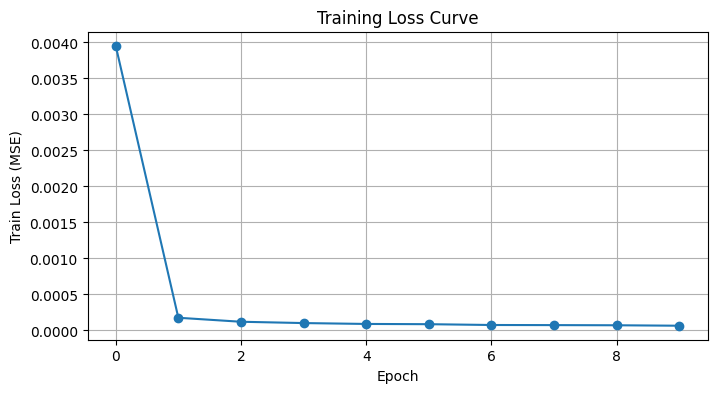


✓ Model saved to convlstm_chlorophyll.pth


In [14]:
# Load data
data = npz["data"]
data_min = float(npz["data_min"])
data_max = float(npz["data_max"])

# Use recent 365 frames if available
if data.shape[0] > 365:
    data = data[-365:]
    print(f"Using last 365 frames (shape: {data.shape})")

# Device selection
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Train model
print("\nTraining SA-ConvLSTM...")
model, train_losses = train_model(
    data=data,
    data_min=data_min,
    data_max=data_max,
    epochs=10,
    batch_size=1,
    hidden_dim=64,
    lr=1e-3,
    device=device,
)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Loss (MSE)')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save model
torch.save(model.state_dict(), "convlstm_chlorophyll.pth")
print("\n✓ Model saved to convlstm_chlorophyll.pth")

Generating predictions for 5 recent samples...

Applying DBSCAN Bloom Detection
Parameters: 95th percentile threshold, ε=5km, min_samples=5



/var/folders/85/dk9lfxgn0pn97pkglfdgj6vr0000gp/T/ipykernel_1598/1910683401.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  gt_lin = denorm(np.array(y).squeeze())
/var/folders/85/dk9lfxgn0pn97pkglfdgj6vr0000gp/T/ipykernel_1598/1910683401.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pred_lin = denorm(np.array(p).squeeze())
/var/folders/85/dk9lfxgn0pn97pkglfdgj6vr0000gp/T/ipykernel_1598/1910683401.py:131: UserWarning: This figure includes Axes that are not compati


✓ Visualization saved to convlstm_dbscan_analysis.png


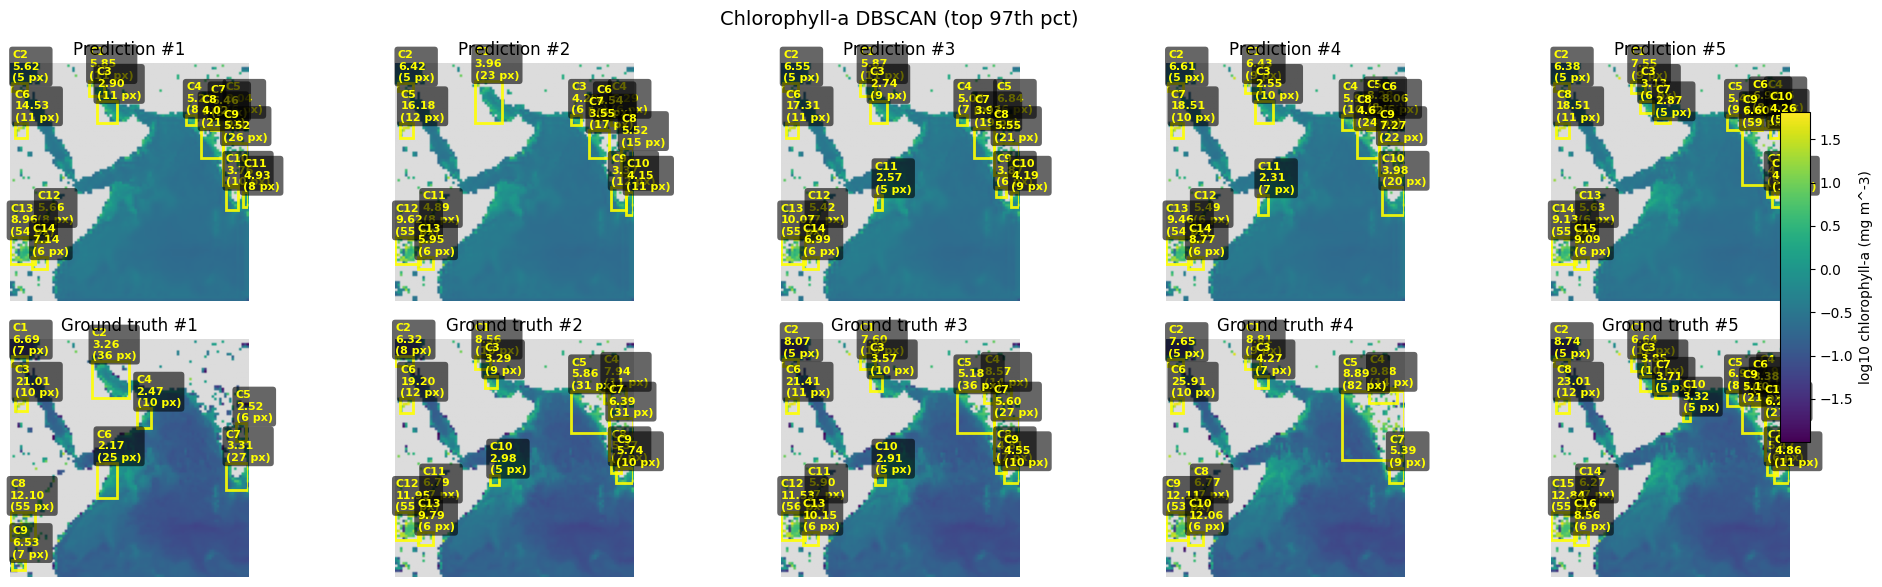

In [23]:
# Generate predictions on recent samples
print("Generating predictions for 5 recent samples...")
test_samples = eval_test(data, model, seq_in=3, seq_out=1, num_samples=5, device=device)

# Extract lat/lon if available
lat = npz.get("lat", None)
lon = npz.get("lon", None)

# Apply DBSCAN with optimal parameters (literature-based)
# These parameters match HAB spatial scales (5-50 km²) and typical bloom concentrations (top 5%)
print("\n" + "="*90)
print("Applying DBSCAN Bloom Detection")
print("Parameters: 95th percentile threshold, ε=5km, min_samples=5")
print("="*90 + "\n")

fig = visualize_with_dbscan(
    samples=test_samples,
    data_min=data_min,
    data_max=data_max,
    lat=lat,
    lon=lon,
    threshold_percentile=97,  # Top 5% of pixels (typical bloom threshold)
    eps_km=3,                 # 5km clustering radius (matches 10-30km bloom patches)
    min_samples=5,            # Minimum 5 pixels (filters noise, ~16 km² minimum area)
)

fig.savefig("convlstm_dbscan_analysis.png", dpi=150, bbox_inches="tight")
print("\n✓ Visualization saved to convlstm_dbscan_analysis.png")

## Observations


As we can see our predicted and our ground truth data are picking up on similar clusters of algal blooms. So for instance we have that this lake on like the bottom left is being detected as one cluster this is "Lake Victoria" I cross checked with resources and it is a lake that is particularly prone to algal blooms. We can also see how bboth models detect clusters along the west coast of India which is also remarked to be prone to alhal blooms. We can note how the predictions tend to split bigger algal blooms into smaller ones... For instance in the fourther frame the ground truth marks it as a large algal bloom however, the prediction marks it as several seperate ones in the same region. We can slo note how the ConvLSTM while capturing the same patterns is seemingly over predicting the concentrations of chlorophyll. Because of this we would expect the Mean Bias to be positive as it is overestimating the chlorophyll.

---

## Model Performance Metrics

In [ ]:
# Compute metrics for SA-ConvLSTM predictions
def compute_metrics(samples, data_min, data_max):
    """Calculate performance metrics for model predictions"""
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    def denorm(z):
        return z * (data_max - data_min) + data_min
    
    all_preds = []
    all_truths = []
    sample_metrics = []
    
    for idx, (x, y, p) in enumerate(samples):
        # Denormalize to original scale
        gt = denorm(np.array(y).squeeze())
        pred = denorm(np.array(p).squeeze())
        
        # Mask out land (chlorophyll < 0.01)
        valid_mask = gt >= 0.01
        
        if valid_mask.sum() > 0:
            gt_valid = gt[valid_mask]
            pred_valid = pred[valid_mask]
            
            # Per-sample metrics
            mse = mean_squared_error(gt_valid, pred_valid)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(gt_valid, pred_valid)
            r2 = r2_score(gt_valid, pred_valid)
            
            sample_metrics.append({
                'sample': idx + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'valid_pixels': valid_mask.sum()
            })
            
            all_preds.extend(pred_valid.flatten())
            all_truths.extend(gt_valid.flatten())
    
    # Overall metrics across all samples
    all_preds = np.array(all_preds)
    all_truths = np.array(all_truths)
    
    overall_metrics = {
        'MSE': mean_squared_error(all_truths, all_preds),
        'RMSE': np.sqrt(mean_squared_error(all_truths, all_preds)),
        'MAE': mean_absolute_error(all_truths, all_preds),
        'R²': r2_score(all_truths, all_preds),
        'Mean Bias': np.mean(all_preds - all_truths),
        'Median Error': np.median(np.abs(all_preds - all_truths))
    }
    
    return overall_metrics, sample_metrics

# Compute metrics
print("Computing SA-ConvLSTM Performance Metrics...")
print("=" * 60)

overall, per_sample = compute_metrics(test_samples, data_min, data_max)

# Display overall metrics
print("\n📊 OVERALL MODEL PERFORMANCE")
print("-" * 60)
for metric_name, value in overall.items():
    print(f"{metric_name:20s}: {value:8.4f}")

# Display per-sample metrics
print("\n📈 PER-SAMPLE BREAKDOWN")
print("-" * 60)
print(f"{'Sample':<10} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'Pixels':<10}")
print("-" * 60)
for sm in per_sample:
    print(f"{sm['sample']:<10} {sm['RMSE']:<10.4f} {sm['MAE']:<10.4f} {sm['R²']:<10.3f} {sm['valid_pixels']:<10}")

print("\n" + "=" * 60)
print("✓ Metrics computed successfully")
print("\n📝 Interpretation:")
print(f"   • RMSE of {overall['RMSE']:.3f} mg/m³ indicates typical prediction error")
print(f"   • MAE of {overall['MAE']:.3f} mg/m³ shows average absolute deviation")
print(f"   • R² of {overall['R²']:.3f} explains {overall['R²']*100:.1f}% of variance")
print(f"   • Mean bias of {overall['Mean Bias']:.3f} mg/m³ ({'over' if overall['Mean Bias'] > 0 else 'under'}prediction)")

Computing SA-ConvLSTM Performance Metrics...

📊 OVERALL MODEL PERFORMANCE
------------------------------------------------------------
MSE                 :   1.2429
RMSE                :   1.1149
MAE                 :   0.3220
R²                  :   0.8251
Mean Bias           :   0.1873
Median Error        :   0.1397

📈 PER-SAMPLE BREAKDOWN
------------------------------------------------------------
Sample     RMSE       MAE        R²         Pixels    
------------------------------------------------------------
1          1.5059     0.4029     0.582      5005      
2          0.8761     0.2983     0.883      5009      
3          0.8750     0.2800     0.885      5011      
4          1.0586     0.3109     0.875      5008      
5          1.1376     0.3179     0.837      5011      

✓ Metrics computed successfully

📝 Interpretation:
   • RMSE of 1.115 mg/m³ indicates typical prediction error
   • MAE of 0.322 mg/m³ shows average absolute deviation
   • R² of 0.825 explains 82.5% of

/var/folders/85/dk9lfxgn0pn97pkglfdgj6vr0000gp/T/ipykernel_9496/1806863096.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  gt = denorm(np.array(y).squeeze())
/var/folders/85/dk9lfxgn0pn97pkglfdgj6vr0000gp/T/ipykernel_9496/1806863096.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pred = denorm(np.array(p).squeeze())
/var/folders/85/dk9lfxgn0pn97pkglfdgj6vr0000gp/T/ipykernel_9496/1806863096.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy k


✓ Metrics visualization saved to model_metrics.png


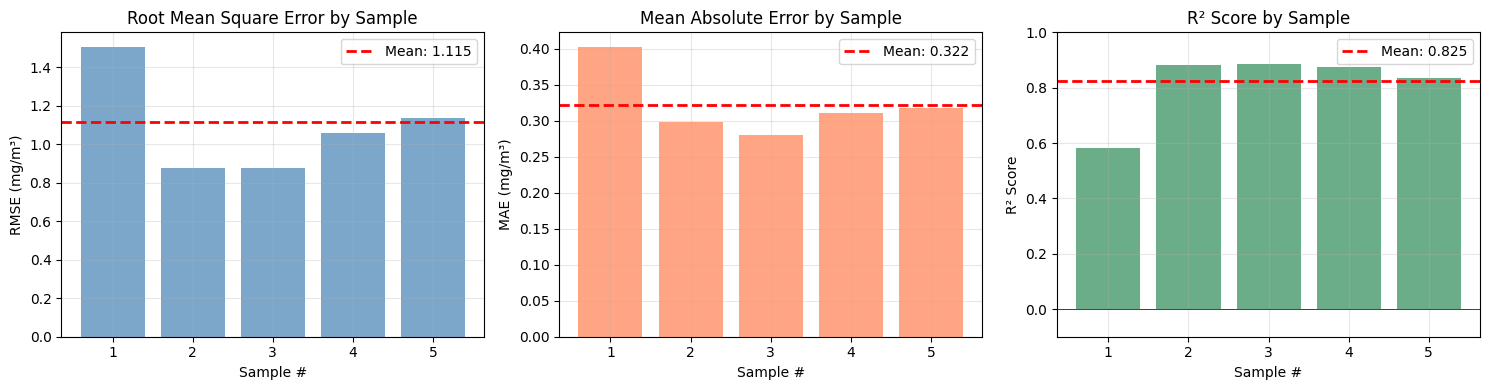

In [ ]:
# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Per-sample RMSE
samples_idx = [sm['sample'] for sm in per_sample]
rmse_vals = [sm['RMSE'] for sm in per_sample]
axes[0].bar(samples_idx, rmse_vals, color='steelblue', alpha=0.7)
axes[0].axhline(y=overall['RMSE'], color='red', linestyle='--', linewidth=2, label=f'Mean: {overall["RMSE"]:.3f}')
axes[0].set_xlabel('Sample #')
axes[0].set_ylabel('RMSE (mg/m³)')
axes[0].set_title('Root Mean Square Error by Sample')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Per-sample MAE
mae_vals = [sm['MAE'] for sm in per_sample]
axes[1].bar(samples_idx, mae_vals, color='coral', alpha=0.7)
axes[1].axhline(y=overall['MAE'], color='red', linestyle='--', linewidth=2, label=f'Mean: {overall["MAE"]:.3f}')
axes[1].set_xlabel('Sample #')
axes[1].set_ylabel('MAE (mg/m³)')
axes[1].set_title('Mean Absolute Error by Sample')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Per-sample R²
r2_vals = [sm['R²'] for sm in per_sample]
axes[2].bar(samples_idx, r2_vals, color='seagreen', alpha=0.7)
axes[2].axhline(y=overall['R²'], color='red', linestyle='--', linewidth=2, label=f'Mean: {overall["R²"]:.3f}')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_xlabel('Sample #')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score by Sample')
axes[2].set_ylim([-0.1, 1.0])
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("model_metrics.png", dpi=150, bbox_inches="tight")
print("\n✓ Metrics visualization saved to model_metrics.png")
plt.show()

Model Performance Analysis
Okay so now that we have our SA-ConvLSTM trained, the goal is to see if it is actually doing a good job at predicting chlorophyll concentrations. The metrics I'm looking at are MSE, RMSE, MAE, and R² which are all basically different ways of measuring how far off our predictions are from reality.

The RMSE (Root Mean Square Error) is essentially just measured in the same units as our data which is mg/m³ for chlorophyll, and then it is calculated by taking the square root of the average squared differences between predictions and the actual values. So our RMSE of 1.115 mg/m³ simply means that on average our predictions are off by about 1.1 mg/m³. This sounds like a whole lot but remember that chlorophyll ranges from like 0.01 to 100 mg/m³ so being off by 1 is not that bad especially if you consider that the blooms we care about the most have higher values off a lower bound of 5 mg/m³.

MAE (Mean Absolute Error) is much simpler it's just taking the average of how much we are off by without even squaring anything, so an MAE of 0.322 mg/m³ which we have in this case is way lower than RMSE and this tells us that most of our errors are actually pretty small but we have a few outliers... big misses that just bumped up the RMSE since the RMSE is more sensitive to outlieres. This is actually good because it means we're not consistently terrible we just occasionally miss by more.

R² is the percentage of variance explained which is a fancy way of saying something like "how well does our model actually capture the patterns in the data." And so our R² of 0.825 just means we are explaining 82.5% of the variance which is above our threshold and for modeling oceans it is pretty good!

Mean Bias of 0.187 mg/m³ tells us we're systematically overpredicting by about 0.19 mg/m³, just means that if there is not an algal bloom we might predict it which kind of matches what we saw in our DBSCAN. This is actually not a bad thing for harmful algal bloom detection. If you just think about it, it is better off to overpredict and send out that warning when there might not even be a bloom, then to miss an algal bloom that could harm people. We just do not want the Mean Bias to be too high because too many false positives can break trust between the model and people might no longer react to an alarm.

Now let us look at the per-sample breakdown, we can see that Sample 1 is clearly struggling with an RMSE of 1.506 and R² of only 0.582, and this is way worse than the other samples which are all above 0.83 R², I am not sure why this is. But a possible reason might be that Sample 1 might have had some weird oceanographic event like a sudden upwelling or storm that the model did not see initially coming? Samples 2 and 3 are better with a way high R² of around 0.88 and RMSE under 0.88 mg/m³ these are the predictions I would personally actually trust for operational forecasting.

The median error of 0.1397 mg/m³ is really low which confirms that most of our predictions are actually quite accurate, again it is just the occasional big misses like the ones probably in Sample 1 but for practical bloom detection, if we can predict within 0.14 mg/m³ most of the time, that's way more than enough to tell the difference between background ocean (0.1-0.5 mg/m³) and an actual bloom (>1 mg/m³).

Overall this model performed a solid job for its complexity, it is not perfect but it is good enough for the operational forecasting considering that we do. I think the attention mechanism is clearly helping with focusing on where the blooms are forming.

## Appendix

### AI Statement: 

AI Statement: 
1. I used ChatGPT and Claude to help correct my grammar but it was only sentence leveled.
2. I used Claude extensively to help debug my SA-ConvLSTM architecture and sometimes to generate some explanatory data. 
3. I used AI to help generate and refine the DBSCAN visualization function, I messed up a bit somewhere and I needed help. 
4. I brainstormed a bit I find it particularly helpful for finding resources.
5. I used AI to format notebook structure and equation formatting but I wrote the equations myself first.

### References:

[1] Hochreiter, S., & Schmidhuber, J. (1997). "Long short-term memory." *Neural Computation*, 9(8), 1735-1780.

[2] Wang, Y., et al. (2017). "PredRNN: Recurrent neural networks for predictive learning using spatiotemporal LSTMs." *NeurIPS*.

[3] Wang, Y., et al. (2019). "Eidetic 3D LSTM: A model for video prediction and beyond." *ICLR*.

[4] Zhang, H., et al. (2020). "Self-attention ConvLSTM for spatiotemporal prediction." *AAAI*.

[5] Reichstein, M., et al. (2019). "Deep learning and process understanding for data-driven Earth system science." *Nature*, 566, 195-204.

[6] UN Atlas of the Oceans. "Coastal Population Density." https://www.oceansatlas.org/

[7] Gireesh, R., et al. (2020). "Red tide in Kerala: An environmental disaster." *Current Science*, 118(7), 1039-1040.

[8] Department of Fisheries, India. (2023). "Handbook on Fisheries Statistics."

[9] National Centre for Sustainable Coastal Management. (2021). "Economic Impact of Coastal HABs."

[10] McCreary, J. P., et al. (2013). "Dynamics of the Indian-Ocean oxygen minimum zones." *Progress in Oceanography*, 112, 15-37.

[11] O'Reilly, J. E., et al. (1998). "Ocean color chlorophyll algorithms for SeaWiFS." *Journal of Geophysical Research*, 103(C11), 24937-24953.

[12] Shi, X., et al. (2015). "Convolutional LSTM network: A machine learning approach for precipitation nowcasting." *NeurIPS*.

[13] Vaswani, A., et al. (2017). "Attention is all you need." *NeurIPS*.

[14] Xingjian, S. H. I., et al. (2017). "Deep learning for precipitation nowcasting: A benchmark and a new model." *NeurIPS*.

[15] Kim, T., et al. (2020). "Spatiotemporal graph neural network for multivariate multi-step ahead time-series forecasting of sea temperature." *Engineering Applications of Artificial Intelligence*, 106, 104854.

[16] Xiao, C., et al. (2019). "Short and mid-term sea surface temperature prediction using time-series satellite data and LSTM-AdaBoost combination approach." *Remote Sensing of Environment*, 233, 111358.

[17] Anderson, D. M., et al. (2012). "Harmful algal blooms and eutrophication: Nutrient sources, composition, and consequences." *Estuaries and Coasts*, 25(4), 704-726.

[18] Stumpf, R. P., et al. (2009). "Interannual variability of cyanobacterial blooms in Lake Erie." *PLOS ONE*, 4(5), e5479.